# CS 584 Assignment 2 -- MLP and Word Vectors

#### Name: Prithvi Vadlamani
#### Stevens ID: 10476457

## Part A: Multi-Layer Perceptron (MLP) (50 Points)

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement the data loading, preprocessing, tokenization, and TF-IDF feature extraction.
3. Implement MLP model, evaluation metrics, and Mini-batch GD with AdaGrad.
4. Implement the MLP with Tensorflow and compare to your implementation.
5. Analysis the results in the Conlusion part.

**Before you start**
- Please read the code very carefully.
- Install these packages (jupyterlab, matplotlib, nltk, numpy, scikit-learn, tensorflow, tensorflow_addons, pandas) using the following command.
```console
pip install -r requirements.txt
```
- It's better to train the Tensorflow model with GPU and CUDA. If they are not available on your local machine, please consider Google CoLab. You can check `CoLab.md` in this assignments.
- You are **NOT** allowed to use other packages unless otherwise specified.
- You are **ONLY** allowed to edit the code between `# Start your code here` and `# End` for each block.

In [1]:
# you may not run this cell after the first installation
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf


tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. Data Processing (5 points)

* Download the dataset from Canvas
* Load data to text and labels
* Preprocessing
* Tokenization
* Split data
* Feature extraction (TF-IDF)

#### Download NLTK stopwords

In [3]:
import os

import nltk


nltk_path = os.path.join('a2-data', 'nltk')
nltk.download('stopwords', download_dir=nltk_path)
nltk.data.path.append(nltk_path)

[nltk_data] Downloading package stopwords to a2-data/nltk...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
import sys


def print_line(*args):
    """ Inline print and go to the begining of line
    """
    args1 = [str(arg) for arg in args]
    str_ = ' '.join(args1)
    sys.stdout.write(str_ + '\r')
    sys.stdout.flush()

In [5]:
from typing import List, Tuple, Union,Dict

import numpy as np

### 1.1 Load data

- Load sentences and labels
- Transform string labels into integers

In [6]:
def load_sentence_label(data_path: str) -> Tuple[List[str], List[str]]:
    """ Load sentences and labels from the specified path
    Args:
        data_path: data_path: path to the data file, e.g., 'a1-data/SMSSpamCollection'
        sentences: the raw text list of all sentences
    Returns:
        labels: the label list of all sentences
    """
    sentences, labels = [], []
    # Start your code here (load text and label from files)
    corpus = open("books.txt")

    for sent in corpus:
      line = sent.split("\t")
      labels.append(line[0])
      sentences.append(line[1])
    # End
    return sentences, labels

In [7]:
data_path = os.path.join('a2-data', 'books.txt')
sentences, labels = load_sentence_label(data_path)

label_map = {}
for label in sorted(list(set(labels))):
    label_map[label] = len(label_map)
labels = np.array([label_map[label] for label in labels], dtype=int)
sentences = np.array(sentences, dtype=object)

print('Label map:', label_map)
print('Number of sentences and labels:', len(sentences), len(labels))

Label map: {'Arthur Conan Doyle': 0, 'Fyodor Dostoyevsky': 1, 'Jane Austen': 2}
Number of sentences and labels: 19536 19536


#### Split the data into training, validation and test

In [8]:
def train_test_split(sentences: np.ndarray,
                     labels: np.ndarray,
                     test_ratio: float = 0.2) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """ Split the sentences and labels into training and test data by shuffling
    Args:
        sentences: A numpy array containing all sentences
        labels: A number array containing label ids
        test_ratio: A float number to calculate the number of test data

    Returns:
        train_sentences: A numpy array containing all training sentences
        train_labels: A number array containing all training label ids
        test_sentences: A numpy array containing all test sentences
        test_labels: A number array containing all test label ids
    """
    assert 0 < test_ratio < 1
    assert len(sentences) == len(labels)

    train_index, test_index = [], []
    # Start your code here (split the index for training and test)

    length = len(sentences)
    n_test = int(np.ceil(length*test_ratio))
    n_train = length - n_test
    
    perm = np.random.permutation(length)
    test_index = perm[:n_test]
    train_index = perm[n_test:]

    # End

    train_sentences, train_labels = sentences[train_index], labels[train_index]
    test_sentences, test_labels = sentences[test_index], labels[test_index]
    return train_sentences, train_labels, test_sentences, test_labels

In [9]:
np.random.seed(6666)

test_ratio = 0.2
valid_ratio = 0.1
(train_sentences, train_labels,
    test_sentences, test_labels) = train_test_split(sentences, labels, test_ratio)
(train_sentences, train_labels,
    valid_sentences, valid_labels) = train_test_split(train_sentences, train_labels, valid_ratio)

print('Training data length:', len(train_sentences))
print('Validation data length:', len(valid_sentences))
print('Test data length:', len(test_sentences))

Training data length: 14065
Validation data length: 1563
Test data length: 3908


In [10]:
def count_label(labels: np.ndarray, label_map: Dict[str, int]) -> Dict[str, int]:
    
    """
    Args:
        labels: The labels of a dataset 
        label_map: The mapping from label to label id
    Returns:
        label_count: The mapping from label to its count
    """
    
    label_count = {key: 0 for key in label_map.keys()}
    
    # Start your code here (count the number of each label)

    label_count = {a: list(labels).count(a) for a in labels}

    # End
    return label_count    

In [11]:
print('Training:', count_label(train_labels, label_map))
print('Validation:', count_label(valid_labels, label_map))
print('Test:', count_label(test_labels, label_map))

Training: {0: 1871, 1: 4239, 2: 7955}
Validation: {2: 912, 1: 459, 0: 192}
Test: {2: 2187, 1: 1246, 0: 475}


#### Dataset statistics
Fill this table with the statistics you just printed (double click this cell to edit)
|                | Arthur Conan Doyle | Fyodor Dostoyevsky | Jane Austen | Total |
|:--------------:|--------------------|--------------------|-------------|-------|
|  **Training**  |        1871        |        4239        |     7955    |       |
| **Validation** |         192        |         459        |      912       |       |
|    **Test**    |         475        |        1246        |     2187    |       |
|    **Total**   |        2538        |        5944        |    11054    |       |

### 1.2 Preprocess
In this section, you need to remove all the unrelated characters, including punctuation, urls, and numbers. Please fill up the functions and test them by running the following cell.

In [12]:
import re


class Preprocessor:
    def __init__(self, punctuation=True, url=True, number=True):
        self.punctuation = punctuation
        self.url = url
        self.number = number

    def apply(self, sentence: str) -> str:
        """ Apply the preprocessing rules to the sentence
        Args:
            sentence: raw sentence
        Returns:
            sentence: clean sentence
        """
        sentence = sentence.lower()
        if self.url:
            sentence = Preprocessor.remove_url(sentence)
        if self.punctuation:
            sentence = Preprocessor.remove_punctuation(sentence)
        if self.number:
            sentence = Preprocessor.remove_number(sentence)
        sentence = re.sub(r'\s+', ' ', sentence)
        return sentence

    @staticmethod
    def remove_punctuation(sentence: str) -> str:
        """ Remove punctuations in sentence with re
        Args:
            sentence: sentence with possible punctuations
        Returns:
            sentence: sentence without punctuations
        """
        # Start your code here
        sentence = re.sub(pattern = "[^\w\s]",
              repl = "",
              string = sentence)
        # End
        return sentence

    @staticmethod
    def remove_url(sentence: str) -> str:
        """ Remove urls in text with re
        Args:
            sentence: sentence with possible urls
        Returns:
            sentence: sentence without urls
        """
        # Start your code here
        sentence = re.sub(pattern = r"http\S+", 
                         repl = "",
                         string = sentence)
        # End
        return sentence

    @staticmethod
    def remove_number(sentence: str) -> str:
        """ Remove numbers in sentence with re
        Args:
            sentence: sentence with possible numbers
        Returns:
            sentence: sentence without numbers
        """
        # Start your code here
        sentence = re.sub(pattern = "[0-9]*",
                         repl = "",
                         string = sentence)
        # End
        return sentence

##### Test your implementation by running the following cell.

In [13]:
sentence = "Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."

processor = Preprocessor()
clean_sentence = processor.apply(sentence)

print(f'"{sentence}"') 
print('===>')
print(f'"{clean_sentence}"')

"Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."
===>
"interest rates are trimmed to by the south african central bank but the lack of warning hits the rand and surprises markets"


### 1.3 Tokenization

In [14]:
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk.corpus import stopwords


stopwords_set = set(stopwords.words('english'))
stemmer = PorterStemmer()
print(list(stopwords_set)[:10])

['against', 'don', 'our', 'there', 'under', 'can', 'my', 'more', 'you', 'did']


In [15]:
def tokenize(sentence: str) -> List[str]:
    """ Tokenize a sentence into tokens (words)
    Args:
        sentence: clean sentence
    Returns:
        tokens
    """
    words = []
    # Start your code here
    #     Step 1. Split sentence into words
    #     Step 2. Extract word stem using the defined stemmer (PorterStemmer) by calling stemmer.stem(word)
    #     Step 3. Remove stop words using the defined stopwords_set
    sentence = " ".join(sentence.split()) # Split
    notes = sentence.split(" ")
    
    rootWords = [] # Stemming
    ps = PorterStemmer()
    for w in notes:
        rootWord = ps.stem(w)
        rootWords.append(rootWord)
        
    stopWords = set(stopwords.words('english'))  # Stop words
    for i in rootWords:
        if i not in stopWords:
            words.append(i)
    # End
    return words

##### Test your implementation by running the following block.

In [16]:
sentence = "Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."

processor = Preprocessor()
clean_sentence = processor.apply(sentence)
tokens = tokenize(clean_sentence)

print(f'"{sentence}"') 
print('===>')
print(f'"{tokens}"')

"Interest rates are trimmed to 7.5 by the South African central bank (https://www.xxx.xxx), but the lack of warning hits the rand and surprises markets."
===>
"['interest', 'rate', 'trim', 'south', 'african', 'central', 'bank', 'lack', 'warn', 'hit', 'rand', 'surpris', 'market']"


### 1.5 Feature Extraction

TF-IDF:
$$\text{TF-IDF}(t, d) = \frac{f_{t, d}}{\sum_{t'}{f_{t', d}}} \times \log{\frac{N}{n_t}}$$

- $t$: A term
- $d$: A document. Here, we regard a sentence as a document
- $f_{t, d}$: Number of term $t$ in $d$
- $N$: Number of document
- $n_t$: Number of document containing $t$

In [17]:
from collections import defaultdict


class TfIdfEncoder:
    def __init__(self):
        self.vocab = defaultdict(int)
        self.token2index = {}
        self.df = defaultdict(int)
        self.num_doc = 0
        self.processor = Preprocessor()

    def fit(self, sentences: Union[List[str], np.ndarray]) -> int:
        """ Using the given texts to store key information in TF-IDF calculation
            In this function, you are required to implement the fitting process.
                1. Construct the vocabulary and store the frequency of tokens (self.vocab).
                2. Construct the document frequency map to tokens (self.df).
                3. Construct the token to index map based on the frequency.
                   The token with a higher frequency has the smaller index
        Args:
            sentences: Raw sentences
        Returns:
            token_num
        """
        self.num_doc = len(sentences)
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == len(sentences) - 1:
                print_line('Fitting TF-IDF encoder:', (i + 1), '/', len(sentences))
            # Start your code here (step 1 & 2)

            self.processor = Preprocessor()
            clean_sentence = self.processor.apply(sentence)
            tokens = tokenize(clean_sentence)

            for word in tokens:
                if word in self.vocab:
                    self.vocab[word] += 1
                else:
                    self.vocab[word] = 1
                    
                    
            tokens_set = set(tokens)
            
            for word in tokens_set:
                if word in self.df:
                    self.df[word] +=1
                else:
                    self.df[word] = 1

            # End
        print_line('\n')
        # Start your code here (Step 3)

        self.token2index = dict(sorted(self.vocab.items()), key = lambda x:x[1], reverse=True) #{token:highest_freq}
        i = 0
        for key, value in self.token2index.items():
            self.token2index[key] = i
            i+=1    

        # End
        token_num = len(self.token2index) 
        print('The number of distinct tokens:', token_num)
        return token_num

    def encode(self, sentences: Union[List[str], np.ndarray]) -> np.ndarray:
        """ Encode the sentences into TF-IDF feature vector
            Note: if a token in a sentence does not exist in the fit encoder, we just ignore it.
        Args:
            sentences: Raw sentences
        Returns:
            features: A (n x token_num) matrix, where n is the number of sentences
        """
        n = len(sentences)
        features = np.zeros((n, len(self.token2index)))
        for i, sentence in enumerate(sentences):
            if i % 100 == 0 or i == n - 1:
                print_line('Encoding with TF-IDF encoder:', (i + 1), '/', n)
            # Start your code (calculate TF-IDF)

            tfDict = {}
            idfDict = {}
            bowCount = len(sentence)
            
            for word in sentence:
                if word in tfDict:
                    tfDict[word] +=1
                else:
                    tfDict[word] = 1
                    
                tf = tfDict[word]/float(len(sentence))
                
                #IDF
                try:
                    idf = np.log(n/self.df[word])
                except:
                    idf = np.log(n)
                
                tfIDF = tf*idf
                
                if word in self.token2index:
                    features[i][self.token2index[word]] = tfIDF
                    
            # End
        print_line('\n')
        return features

##### Test your implementation by running the following cell.

In [18]:
encoder = TfIdfEncoder()
encoder.fit(train_sentences[:100])
features = encoder.encode(train_sentences[:10])

print(features[:5])


The number of distinct tokens: 1335

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Encode training, validation, and test dataset

In [19]:
num_class = 3

encoder = TfIdfEncoder()
vocab_size = encoder.fit(train_sentences)

x_train = encoder.encode(train_sentences)
x_valid = encoder.encode(valid_sentences)
x_test = encoder.encode(test_sentences)

y_train = np.zeros((len(train_labels), num_class))
y_valid = np.zeros((len(valid_labels), num_class))
y_test = np.zeros((len(test_labels), num_class))
y_train[np.arange(len(train_labels)), train_labels] = 1
y_valid[np.arange(len(valid_labels)), valid_labels] = 1
y_test[np.arange(len(test_labels)), test_labels] = 1

print('The size of training set:', x_train.shape, y_train.shape)
print('The size of validation set:', x_valid.shape, y_valid.shape)
print('The size of test set:', x_test.shape, y_test.shape)


The number of distinct tokens: 16825



The size of training set: (14065, 16825) (14065, 3)
The size of validation set: (1563, 16825) (1563, 3)
The size of test set: (3908, 16825) (3908, 3)


## 2. MLP (20 Points)
In this section, you are required to implement a two-layer MLP model (input -> hidden layer -> output layer) with $L_2$ regularization from scratch. 

The objective function of LR for multi-class classification:

$$J = L(\mathbf{x}, \mathbf{y} \mid \mathbf{w}, \mathbf{b}) = -\frac{1}{n}\sum_{i=1}^{N}\sum_{k=1}^{K}y_{ik}log\frac{e^{f_k}}{\sum_{c=1}^{K}e^{f_c}} + \lambda \sum_{j=1}^{d}w_{kj}^2$$

- $z_1 = w_1x$
- $h_1 = activation(z_1)$
- $z_2 = w_2 h_1$
- $\hat{y} = softmax(z_2)$

- $n$: Number of samples
- $d$: Dimension of $\mathbf{w}$
- Here, you can use `sigmoid` as the activation function for the hidden layer.

### 2.1 MLP Model (5 Points)

In [20]:
def softmax(x: np.ndarray, axis: int = -1) -> np.ndarray:
    """ The softmax activation function
    Args:
        x: Input matrix or vector
        axis: The dimension of x that needs to run softmax, default -1, i.e., the last dimension
    Returns:
        output: Softmax value of the specified dimension in x
    """
    # Start your code here
    # e = np.exp(x-np.max(x))

    # for i in range(len(x)):
    #   e[i] /= np.sum(e[i])
    num = x - np.max(x, axis = axis).reshape(x.shape[0],1)
    x = np.exp(num) / np.sum(np.exp(x), axis = axis).reshape(x.shape[0],1)
    # End
    return x


def sigmoid(x: np.ndarray) -> np.ndarray:
    """ The sigmoid activation function
    Args:
        x: Input matrix or vector
    Returns:
        output: Sigmoid value of each entry in x
    """
    # Start your code here
    x = 1/(1+np.exp(-x))
    # End
    return x

In [21]:
class MLP:
    def __init__(self, feature_dim: int, hidden_dim: int, num_class: int, lambda_: float):
        """ MLP Model
        Args:
            feature_dim: feature dimension
            hidden_dim: hidden units
            num_class: number of class
            lambda_: lambda in L2 regularizer
        """
        # Start your code here (initialize weight and bias)
        # self.w1 =
        # self.b1 =
        # self.w2 =
        # self.b2 =
        self.w1 = np.random.uniform(size = (feature_dim, hidden_dim))
        self.b1 = np.random.uniform(size = (1, hidden_dim))

        self.w2 = np.random.uniform(size = (hidden_dim, num_class))
        self.b2 = np.random.uniform(size = (1, num_class))
        # End
        self.lambda_ = lambda_
        self.eps = 1e-9

    def forward(self, x: np.ndarray, return_hiddens: bool = False) -> np.ndarray:
        """ Forward process of logistic regression
            Calculate y_hat using x
        Args:
            x: Input data
            return_hiddens: If true the function will return h1 for gradient calculation
        Returns:
            y_hat: Output
            h1: Hidden output, used for gradient calculation. Returned if return_hiddens is set to True
        """
        y_hat = 0
        h1 = 0, 0
        w1, b1, w2, b2 = self.w1, self.b1, self.w2, self.b2
        # Start your code here (calculate y_hat of MLP using x)

        h1 = sigmoid(np.dot(x, self.w1) + self.b1)
        y_hat = softmax(np.dot(h1, self.w2) + self.b2, axis=1)        

        # End
        if return_hiddens:
            return y_hat, h1
        else:
            return y_hat

    def backward(self,
                 x: np.ndarray,
                 y_hat: np.ndarray,
                 y: np.ndarray,
                 h1: np.array) -> Tuple[np.ndarray, Union[float, np.ndarray], np.ndarray, Union[float, np.ndarray]]:
        """ Backward process of logistic regression
            Calculate the gradient of w and b
        Args:
            x: Input data
            y_hat: Output of forward
            y: Ground-truth
            h1: Hidden output of the hidden layer
        Returns:
            dw1: Gradient of w1
            db1: Gradient of b1
            dw2: Gradient of w2
            db2: Gradient of b2
        """
        w1, w2 = self.w1, self.w2
        dw1, db1, dw2, db2 = 0.0, 0.0, 0.0, 0.0
        n = len(x)

        # Start your code here (calculate the gradient of w and b)

        dw2 = (1/n) * np.dot(h1.T, (y_hat - y)) + (self.lambda_ * np.sum(2 * w2))
        # db2 = (1/ n) * np.sum(y_hat - y).T.reshape(1,-1) #(3,) -> (,3) -> #(1,3)
        db2 = (1/n)*(np.sum((y_hat - y), axis = 0))  

        #dw1 = (1/n) * np.dot(np.dot(np.dot(h1,(1-h1).T),x).T, np.dot(y_hat-y,w2.T)) + (self.lambda_ * np.sum(2 * w1))
        #db1 = (1/n) * np.sum(np.dot(np.dot(y_hat-y,w2.T).T,np.dot(h1,(1-h1).T)),axis=1).reshape(1,-1)
        
        a = np.dot((y_hat - y), w2.T)
        b = np.multiply(a, h1) 
        c = np.multiply(b,(1-h1)) 
        d = np.dot(x.T,c)

        dw1 = (1/n) * d 
        db1 = (1/n) * np.sum(c, axis=0) 


        
        

        # End
        return dw1, db1, dw2, db2

    def categorical_cross_entropy_loss(self,
                                       y_hat: np.ndarray,
                                       y: np.ndarray) -> Union[float, np.ndarray]:
        """ Calculate the binary cross-entropy loss
        Args:
            y_hat: Output of forward
            y: Ground-truth
        Returns:
            loss: BCE loss
        """
        y_hat = np.clip(y_hat, a_min=self.eps, a_max=1 - self.eps)
        loss = 0
        # Start your code here (Calculate the binary cross-entropy)
        loss = -np.mean(y*np.log(y_hat)) + self.lambda_*np.sum((self.w2)**2)
        # End
        return loss

    def gradient_descent(self, dw1: np.ndarray, db1: Union[np.ndarray, float], dw2: np.ndarray, db2: Union[np.ndarray, float], lr: float):
        #print(self.b1.shape, db1.shape)
        self.w1 -= lr * dw1
        self.b1 -= lr * db1
        self.w2 -= lr * dw2
        self.b2 -= lr * db2

    def predict(self, y_hat: np.ndarray) -> np.ndarray:
        """ Predict the label using the output y_hat
        Args:
            y_hat: Model output
        Returns:
            pred: Prediction
        """
        pred = np.zeros_like(y_hat)
        index = np.argmax(y_hat, axis=-1)
        pred[np.arange(len(y_hat)), index] = 1
        return pred

### 2.2 Evaluation Metrics

Accuracy, Precision, Recall, F1

In [22]:
from sklearn.metrics import precision_recall_fscore_support,accuracy_score


def get_metrics(y_pred: np.ndarray, y_true: np.ndarray) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray]:
    """ Calculate the accuracy, precision, recall, and f1 score.
        You are allowed to use precision_recall_fscore_support from scikit-learn. Please set average to 'micro'
    Args:
        y_pred: Prediction
        y_true: Ground-truth
    Returns:
        accuracy: float number. The accuracy for the whole dataset
        precision, recall, f1: np.ndarray (num_class, ). The precision, recall, f1 for each class
    """
    assert y_pred.shape == y_true.shape
    accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0
    # Start your code here
    #precision, recall, f1 = precision_recall_fscore_support(y_true, y_pred, average='micro')
    TN = TP = FN = FP = 0
    """
    for i in range(len(y_pred[0])):        
        
        if y_pred[i] == 0 and y_true[i] == 0:
            TN += 1
        elif y_pred[i] == 0 and y_true[i] == 1:
            FP += 1
        elif y_pred[i] == 1 and y_true[i] == 0:
            FN += 1
        elif y_pred[i] == 1 and y_true[i] == 1:
            TP += 1
            
            
    accuracy = accuracy/(len(y_pred[0]))

    try:
        precision = (TP)/(FP + TP)
        recall = (TP)/(FN + TP)
    
        f1 = (2*precision*recall)/(precision + recall)
        
    except:
        precision = recall = f1 = 0
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average = 'micro')
        
        
    # End
    return accuracy, precision, recall, f1

### 2.3 AdaGrad (5 points)

$$ \mathbf{G}^{(t + 1)} \leftarrow \mathbf{G}^{(t)} + \boldsymbol{g}^{(t + 1)} \cdot \boldsymbol{g}^{(t + 1)} $$
$$ \mathbf{w}^{(t + 1)} \leftarrow \mathbf{w}^{(t)} - \frac{\eta}{\sqrt{\mathbf{G}^{(t + 1)} + \epsilon}}\boldsymbol{g}^{(t + 1)} = \mathbf{w}^{(t)} - \eta\frac{\boldsymbol{g}^{(t + 1)}}{\sqrt{\mathbf{G}^{(t + 1)} + \epsilon}} $$

In [23]:
class AdaGrad:
    def __init__(self, init_lr, model):
        self.init_lr = init_lr
        self.model = model
        
        self.accumulative_dw1 = 0
        self.accumulative_db1 = 0
        self.accumulative_dw2 = 0
        self.accumulative_db2 = 0
        self.eps = 1e-9
        
    def update(self, dw1: np.ndarray, db1: Union[np.ndarray, float], dw2: np.ndarray, db2: Union[np.ndarray, float]):
        """ 1. Use the gradient in the current step to update the accumulative gradient of each parameter.
            2. Calculate the new gradient with the accumulative gradient
            3. Use the init learning rate the new gradient to update the parameter with model.gradient_descent()
        
        Do not return anything
        """
        # Start your code here
        # Step 1
        #print(np.square(db1).shape)
        self.accumulative_dw1 += np.square(dw1)
        self.accumulative_dw2 += np.square(dw2)
        self.accumulative_db1 += np.square(db1)
        self.accumulative_db2 += np.square(db2)        
        
        # Step 2
        
        dw1 = dw1/(np.sqrt(self.accumulative_dw1 + self.eps))
        dw2 = dw2/(np.sqrt(self.accumulative_dw2 + self.eps))
        db1 = db1/(np.sqrt(self.accumulative_db1 + self.eps))
        db2 = db2/(np.sqrt(self.accumulative_db2 + self.eps))

        # Step 3

        self.model.gradient_descent(dw1, db1, dw2, db2, self.init_lr)

        # End

        

### 2.4 Mini-batch Gradient Descent (5 Points)

In [24]:
from collections import OrderedDict


def train_mbgd(model: 'MLP',
               x_train: np.ndarray,
               y_train: np.ndarray,
               x_valid: np.ndarray,
               y_valid: np.ndarray,
               lr: float,
               num_epoch: int,
               batch_size: int,
               print_every: int = 10) -> Tuple[Dict[str, List], Dict[str, List]]:
    """ Training with Gradient Descent
    Args:
        model: The logistic regression model
        x_train: Training feature, (n x d) matrix
        y_train: Training label, (n, ) vector
        x_valid: Validation feature, (n x d) matrix
        y_valid: Validation label, (n, ) vector
        lr: Learning rate
        num_epoch: Number of training epochs
        batch_size: Number of training samples in a batch
        print_every: Print log every {print_every} epochs
    Returns:
        train_history: Log of training information. The format of training history is
                       { 'loss': [] }
                       It records the average loss of each epoch.
        valid_history: Log of validation information. The format of training and validation history is
                       {
                           'loss': [],
                           'accuracy': [],
                           'precision': [],
                           'recall': [],
                           'f1': []
                       }
    """
    train_history = OrderedDict({'loss': []})
    valid_history = OrderedDict({
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    })

    def format_output(epoch, num_epoch, train_history, valid_history):
        epoch_log = f'Epoch {epoch + 1} / {num_epoch}'
        train_log = ' - '.join([f'train_{key}: {val[-1]:.4f}' for key, val in train_history.items()])
        valid_log = ' - '.join([f'valid_{key}: {val[-1]:.4f}' for key, val in valid_history.items()])
        log = f'{epoch_log}: {train_log} - {valid_log}'
        return log

    # IMPORTANT: YOU SHOULD USE THIS OPTIMIZER TO UPDATE THE MODEL
    optimizer = AdaGrad(init_lr=lr, model=model)

    train_num_samples = len(x_train)
    n_batch = train_num_samples // batch_size
    for epoch in range(num_epoch):
        epoch_loss = 0.0
        # Start your code here (training)
        #     Step 1. Model forward
        #     Step 2. Calculate loss
        #     Step 3. Model backward
        #     Step 4. Optimization with Adagrad

        for i in range(n_batch):
            #x_batch = x_train[(i*batch_size) : (i*batch_size)+((i*batch_size)+batch_size)]
            #y_batch = y_train[(i*batch_size) : (i*batch_size)+((i*batch_size)+batch_size)]
            x_batch = x_train[i : i+batch_size]
            y_batch = y_train[i : i+batch_size]
            y_hat,h1 = model.forward(x_batch, return_hiddens = True)
            epoch_loss += model.categorical_cross_entropy_loss(y_hat, y_batch)
            dw1, db1, dw2, db2 = model.backward(x_batch, y_hat, y_batch, h1)
            #model.gradient_descent(model.dw1, model.db1, model.dw2, model.db2, lr)
            optimizer.update(dw1, db1, dw2, db2)
        #epoch_loss = epoch_loss/n_batch

        

        # End

        valid_loss = 0.
        accuracy, precision, recall, f1 = 0.0, 0.0, 0.0, 0.0
        # Start your code here (validation)
        #     Step 1. Predict
        #     Step 2. Calculate loss
        #     Step 3. Calculate metrics

        y_hat = model.forward(x_valid, return_hiddens = False)
        y_hat = model.predict(y_hat)
        valid_loss = model.categorical_cross_entropy_loss(y_hat, y_valid)
        accuracy, precision, recall, f1 = get_metrics(y_hat, y_valid)

        # End

        train_history['loss'].append(epoch_loss / train_num_samples)
        for vals, val in zip(valid_history.values(), [valid_loss, accuracy, precision, recall, f1]):
            vals.append(val)
        log = format_output(epoch, num_epoch, train_history, valid_history)
        if epoch % print_every == 0 or epoch == num_epoch - 1:
            print(log)
        else:
            print_line(log)

    return train_history, valid_history

Run Mini-batch Gradient Descent

In [25]:
np.random.seed(6666)

hidden_dim = 128
num_epoch = 100
lr = 1e-2
batch_size = 128
lambda_ = 1e-8
print_every = 10

model_mbgd = MLP(feature_dim=vocab_size, hidden_dim=hidden_dim, num_class=num_class, lambda_=lambda_)
mbgd_train_history, mbgd_valid_history = train_mbgd(model_mbgd, x_train, y_train, x_valid, y_valid, lr, num_epoch, batch_size, print_every)

Epoch 1 / 100: train_loss: 0.0535 - valid_loss: 2.8771 - valid_accuracy: 0.5835 - valid_precision: 0.5835 - valid_recall: 0.5835 - valid_f1: 0.5835
Epoch 11 / 100: train_loss: 0.0535 - valid_loss: 2.8771 - valid_accuracy: 0.5835 - valid_precision: 0.5835 - valid_recall: 0.5835 - valid_f1: 0.5835
Epoch 21 / 100: train_loss: 0.0535 - valid_loss: 2.8771 - valid_accuracy: 0.5835 - valid_precision: 0.5835 - valid_recall: 0.5835 - valid_f1: 0.5835
Epoch 31 / 100: train_loss: 0.0535 - valid_loss: 2.8771 - valid_accuracy: 0.5835 - valid_precision: 0.5835 - valid_recall: 0.5835 - valid_f1: 0.5835
Epoch 41 / 100: train_loss: 0.0535 - valid_loss: 2.8771 - valid_accuracy: 0.5835 - valid_precision: 0.5835 - valid_recall: 0.5835 - valid_f1: 0.5835
Epoch 51 / 100: train_loss: 0.0535 - valid_loss: 2.8771 - valid_accuracy: 0.5835 - valid_precision: 0.5835 - valid_recall: 0.5835 - valid_f1: 0.5835
Epoch 61 / 100: train_loss: 0.0535 - valid_loss: 2.8771 - valid_accuracy: 0.5835 - valid_precision: 0.5835 

### 2.5 MLP using Tensorflow (5 Points)

In [26]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Softmax
from tensorflow.keras.activations import sigmoid


class MLPTF(Model):
    def __init__(self, feature_dim: int, hidden_dim: int, num_class: int, lambda_: float):
        """ MLP Model using tensorflow.keras
        Args:
            feature_dim: feature dimension
            hidden_dim: hidden units
            num_class: number of class
            lambda_: lambda in L2 regularizer
        """
        super().__init__()
        # Start your code here (initialize weight and bias)
        # self.dense1 =
        # self.dense2 =
        # self.softmax = 
        self.dense1 = tf.keras.layers.Dense(hidden_dim, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(lambda_), use_bias=True, bias_regularizer =tf.keras.regularizers.L2(lambda_), activity_regularizer= tf.keras.regularizers.L2(lambda_))
        self.dense2 = tf.keras.layers.Dense(num_class, activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(lambda_), use_bias=True, bias_regularizer =tf.keras.regularizers.L2(lambda_), activity_regularizer= tf.keras.regularizers.L2(lambda_))
        # End
        
    def call(self, x):
        """ Forward function of tf. It should be named 'call'
        
        Args:
            x: (n x feature_dim) tensor
        Returns:
            y_hat: (n x num_class) tensor
        """
        # Start your code here (Forward)
        h1 = self.dense1(x)
        y_hat = self.dense2(h1)
        # End
        return y_hat

In [27]:
import tensorflow_addons as tfa
np.random.seed(6666)
tf.random.set_seed(6666)


hidden_dim = 128
num_epoch = 100
lr = 1e-1
batch_size = 128
lambda_ = 1e-8

model_tf = MLPTF(feature_dim=vocab_size, hidden_dim=hidden_dim, num_class=num_class, lambda_=lambda_)
model_tf.build(input_shape=(None, vocab_size))
model_tf.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(), tfa.metrics.F1Score(num_classes=num_class, average='micro')])
model_tf.summary()

Model: "mlptf"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  2153728   
                                                                 
 dense_1 (Dense)             multiple                  387       
                                                                 
Total params: 2,154,115
Trainable params: 2,154,115
Non-trainable params: 0
_________________________________________________________________


In [28]:
tf_history = model_tf.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), batch_size=batch_size, epochs=num_epoch)

Epoch 1/100
110/110 [==============================] - 5s 10ms/step - loss: 1.0153 - categorical_accuracy: 0.5381 - f1_score: 0.5381 - val_loss: 0.9371 - val_categorical_accuracy: 0.5835 - val_f1_score: 0.5835
Epoch 2/100
110/110 [==============================] - 1s 7ms/step - loss: 0.9664 - categorical_accuracy: 0.5583 - f1_score: 0.5583 - val_loss: 0.9794 - val_categorical_accuracy: 0.5835 - val_f1_score: 0.5835
Epoch 3/100
110/110 [==============================] - 1s 7ms/step - loss: 0.9631 - categorical_accuracy: 0.5571 - f1_score: 0.5571 - val_loss: 0.9311 - val_categorical_accuracy: 0.5835 - val_f1_score: 0.5835
Epoch 4/100
110/110 [==============================] - 1s 8ms/step - loss: 0.9551 - categorical_accuracy: 0.5621 - f1_score: 0.5621 - val_loss: 0.9344 - val_categorical_accuracy: 0.5835 - val_f1_score: 0.5835
Epoch 5/100
110/110 [==============================] - 1s 8ms/step - loss: 0.9506 - categorical_accuracy: 0.5646 - f1_score: 0.5646 - val_loss: 0.9628 - val_catego

#### Evaluation with Tensroflow
You are required to report the loss, accuracy, precision, recall, and f1 on test set and plot the the curve of them for both SGD and Mini-batch GD on train and validation set

In [29]:
# Calculate the metrics for test set and fill in the table below
y_hat = model_mbgd.forward(x_test)
y_pred = model_mbgd.predict(y_hat)
print('Mini-batch GD:', get_metrics(y_pred, y_test))
model_tf.evaluate(x=x_test, y=y_test)

Mini-batch GD: (0.5596212896622313, 0.5596212896622313, 0.5596212896622313, 0.5596212896622313)
123/123 [==============================] - 0s 4ms/step - loss: 0.9049 - categorical_accuracy: 0.5796 - f1_score: 0.5796


[0.9048570990562439, 0.5795803666114807, 0.5795803666114807]

#### Evaluation Metrics on Test set
Fill this table with the result you just printed (double click this cell to edit)
|     Optimizer                     | Accuracy    | F1 Score    |
|:---------------------------------:|-------------|-------------|
|      **Your Implementation**      |   59.13     |    59.13    |
| **Tensorflow**                    |   57.96     |    57.96    |

##### Please run the following cell to plot the training loss curve for Your implementation and Tensorflow

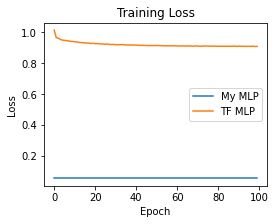

In [30]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(4, 3))
plt.plot(mbgd_train_history['loss'], label='My MLP')
plt.plot(tf_history.history['loss'], label='TF MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

##### Please run the following cell to plot the validation metrics curve for SGD and Mini-batch GD

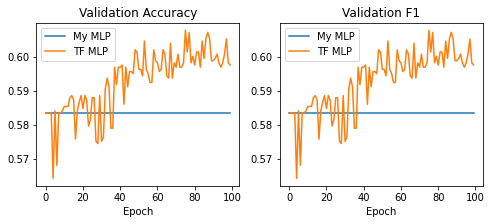

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
ax = axes[0]
ax.plot(mbgd_valid_history['accuracy'], label='My MLP')
ax.plot(tf_history.history['val_categorical_accuracy'], label='TF MLP')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_title('Validation Accuracy')

ax = axes[1]
ax.plot(mbgd_valid_history['f1'], label='My MLP')
ax.plot(tf_history.history['val_f1_score'], label='TF MLP')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_title('Validation F1')
plt.show()

# 3. Conclusion (5 Points)

Provide an analysis for all the results

Answer: The accuracy and f1 scores of implementation and tensorflow are (59.13, 59.13) and (57.96, 57.96) respectively. The issue of less accuracy (loss not updating) might be in token generation.
